# Finding flares on long cadence Kepler light curves

- [Method and Example](#Method-and-Example)
- [Kepler long cadence light curves](#Kepler-long-cadence-light-curves)


In [1]:
import sys

import numpy as np

from astropy.table import Table, Column, vstack

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('../src')

import findflares

In [2]:
lc_info_table = Table.read("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv")

## Method and Example

We use the flare detection method outlined in [Osten et al, 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754....4O/abstract), which was in turn based on [Welch and Stetson, 1993](https://ui.adsabs.harvard.edu/abs/1993AJ....105.1813W) and [Stetson 1996](https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S). We apply this method to the detrended light curves.

The example uses the long cadence light curves, but we use the same method for the short cadence ones.

In [7]:
lc_table = Table.read(lc_info_table["path"][290])

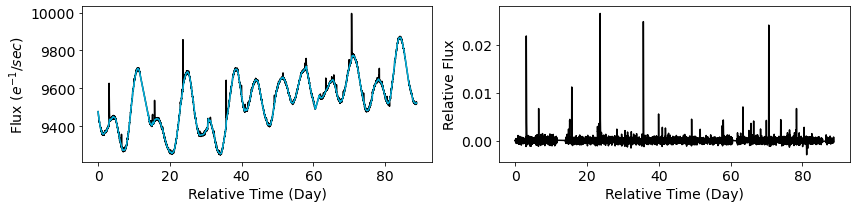

In [40]:
f, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 3))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax1.plot(lc_table['time'].jd - lc_table['time'][0].jd, lc_table['flux'], c='black')
ax1.plot(lc_table['time'].jd - lc_table['time'][0].jd, lc_table['flux_model'], c="#00b2dd")
       
ax1.set_xlabel("Relative Time (Day)", fontsize=14)
ax1.set_ylabel("Flux ($e^{-1}/sec$)", fontsize=14)


ax2.plot(lc_table['time'].jd - lc_table['time'][0].jd, lc_table['flux_detrended'], c='black')

ax2.set_xlabel("Relative Time (Day)", fontsize=14)
ax2.set_ylabel("Relative Flux", fontsize=14)

plt.tight_layout()
plt.show()

- We define a statistic $\phi_{VV} = \left( \frac{V_{rel}}{\sigma} \right)_{i} \times \left( \frac{V_{rel}}{\sigma} \right)_{i+1}$ where $V_{rel,i}$ is the relative (detrended) flux at cadence $i$ and $\sigma_i$ is the error on the flux measurment. This statistic is calculated for every temporal pair of values ($i$ and $i+1$ for all $i$).  
  
  
- Each $\phi_{VV}$ pair is labeled as null ($\phi_{VV}<0$), flare candidate ($\phi_{VV}>0$, $V_{rel,i,i+1}>0$), and excluded ($\phi_{VV}>0$, $V_{rel,i,i+1}<0$).

In [13]:
ws_stat_table, lc_table = findflares.phi_vv_stats(lc_table)

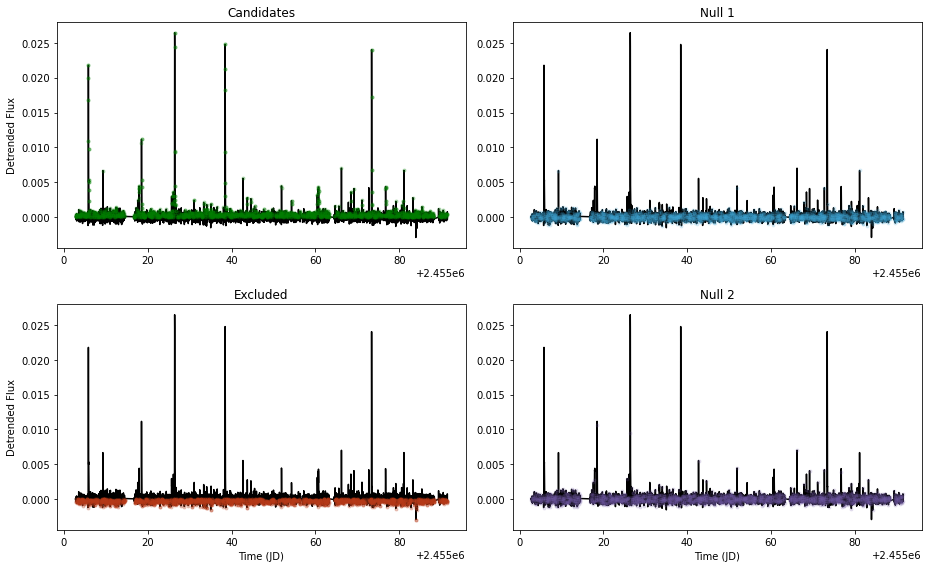

In [17]:
fig = plt.figure(figsize=(13, 8))

# Candidates
ax1 = fig.add_subplot(221)
ax1.plot(lc_table['time'].jd, lc_table['flux_detrended'],color='black', label="Detrended flux")

ax1.plot(ws_stat_table['time_1'][ws_stat_table['candidates']], lc_table['flux_detrended'][:-1][ws_stat_table['candidates']],
         '.', color='green', alpha=0.25, label="Candidates")
ax1.plot(ws_stat_table['time_2'][ws_stat_table['candidates']], lc_table['flux_detrended'][1:][ws_stat_table['candidates']],
         '.', color='green', alpha=0.25, label="Candidates")

ax1.set_title("Candidates")
ax1.set_ylabel("Detrended Flux")

# Null 1
ax2 = fig.add_subplot(222)
ax2.plot(lc_table['time'].jd, lc_table['flux_detrended'],color='black', label="Detrended flux")
ax2.plot(ws_stat_table['time_1'][ws_stat_table['null_1']], lc_table['flux_detrended'][:-1][ws_stat_table['null_1']],
         '.',color='#42a8d7', alpha=0.15, label="Null 1")
ax2.plot(ws_stat_table['time_2'][ws_stat_table['null_1']], lc_table['flux_detrended'][1:][ws_stat_table['null_1']],
         '.',color='#42a8d7', alpha=0.15, label="Null 1")

ax2.set_title("Null 1")

# Null 2
ax3 = fig.add_subplot(224)
ax3.plot(lc_table['time'].jd, lc_table['flux_detrended'],color='black', label="Detrended flux")
ax3.plot(ws_stat_table['time_1'][ws_stat_table['null_2']], lc_table['flux_detrended'][:-1][ws_stat_table['null_2']],
         '.',color='#745da7', alpha=0.15, label="Null 2")
ax3.plot(ws_stat_table['time_2'][ws_stat_table['null_2']], lc_table['flux_detrended'][1:][ws_stat_table['null_2']],
         '.',color='#745da7', alpha=0.15, label="Null 2")

ax3.set_title("Null 2")
ax3.set_xlabel("Time (JD)")

# Excluded
ax4 = fig.add_subplot(223)
ax4.plot(lc_table['time'].jd, lc_table['flux_detrended'],color='black', label="Detrended flux")
ax4.plot(ws_stat_table['time_1'][ws_stat_table['excluded']], lc_table['flux_detrended'][:-1][ws_stat_table['excluded']],
         '.',color='#b83c1b', alpha=0.25, label="Excluded")
ax4.plot(ws_stat_table['time_2'][ws_stat_table['excluded']], lc_table['flux_detrended'][1:][ws_stat_table['excluded']],
         '.',color='#b83c1b', alpha=0.25, label="Excluded")

ax4.set_title("Excluded")
ax4.set_xlabel("Time (JD)")
ax4.set_ylabel("Detrended Flux")

fig.tight_layout()
plt.show()

Now we calulate the histogram for both null pairs (in absolute value) and candidate pairs, and then fit a line to the null sample. The bin width value was chosen empirically. We fit the absolute value of the null samples with a double exponential of the form:

$\alpha e^{-\frac{x-a}{c}} + \beta e^{-\frac{x-a}{c}}$

Calulating the histogram for both null pairs and candidate pairs. Here we start using an extra agument to the `get_hist_bins` function `max_null_val`, to avoid having an excessive number of bins mostly with 0 values, due to a few very high peak flares. The `max_null_val` argument is meant to hold the maximum null `phii_vv` value. If that value is not set, or is within `200*bin_width` of the `max_hist_val`, the histogram bins returned are all `bin_width` wide, however if the `max_hist_val` is more than `200*bin_width` greater than the `max_null_val`, the histogram bins returned are `bin_width` wide up to 100 bins beyomd `max_null_val` and then the rest of the range is split up into 100 bins no matter how wide that makes them. This is done to keep the number of histogram bins reasonable, and does not affect the result because candidate in the bins that much over the maximum null value seen will definitely pass the threshold, so it's fine if they are in larger bins.

In [18]:
hist_bins = findflares.get_hist_bins(ws_stat_table['phi_vv'][ws_stat_table['candidates']].max(),
                                     np.abs(ws_stat_table['phi_vv'][ws_stat_table['null_1'] | ws_stat_table['null_2']]).max())

Number of bins: 242


In [19]:
fit_parameters, covariance = findflares.fit_phi_vv_histogram(ws_stat_table, hist_bins)

Number of null sample bins: 42
332*e^-(x-0.20)/1.15 + 651*e^-(x-0.20)/0.30


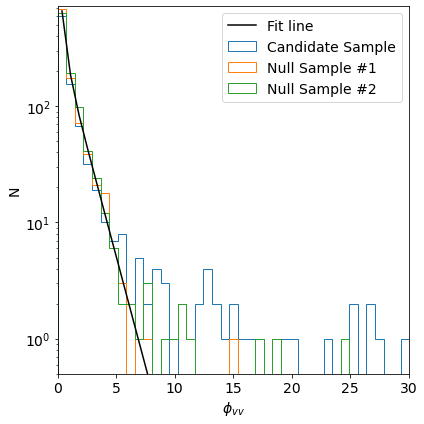

In [31]:
f, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.hist(ws_stat_table['phi_vv'][ws_stat_table['candidates']], hist_bins, histtype='step', 
        stacked=True, fill=False, label="Candidate Sample")

ax.hist(-ws_stat_table['phi_vv'][ws_stat_table['null_1']], hist_bins, histtype='step', 
        stacked=True, fill=False, label="Null Sample #1")

ax.hist(-ws_stat_table['phi_vv'][ws_stat_table['null_2']], hist_bins, histtype='step', 
        stacked=True, fill=False, label="Null Sample #2")

bin_mids = (hist_bins[:-1] + hist_bins[1:])/2
ax.plot(bin_mids, findflares.double_exponential(bin_mids, *fit_parameters), '-', color='black', label="Fit line")

ax.set_ylim(bottom=0.5)
ax.set_yscale("log")
ax.set_xlim(0,30)
ax.legend(fontsize=14)

ax.set_ylabel("N", fontsize=14)
ax.set_xlabel(r"$\phi_{vv}$", fontsize=14)

f.tight_layout()
plt.show()

We caculate the p-value for each candidate $\phi_{VV}$, where the p-value is the probability that a $\phi_{VV}$ from teh null distribution has a value equal to or greater than the candidate $\phi_{VV}$ in question. 

We use false discovery rate (FDR) analysis as described in Miller et al. (2001) to determine a threshold used to limit candidate point to those with $\phi_{VV}$ values at or above that threshold. We set the false discovery rate $\alpha$ to 0.05 or 5%.

Additionally we apply a flux threshold of $3\sigma$ so that no points below $3\sigma$  above the quiescent flux.

In [32]:
findflares.calculate_pvals(ws_stat_table, hist_bins, fit_parameters)
pval_thresh, thresh = findflares.perform_fdr_analysis(ws_stat_table, alpha=0.10)

Pval threshold: 0.00693
Phi_vv threshold: 4.44


In [33]:
sigma_thresh = findflares.apply_sigma_threshold(lc_table, ws_stat_table, threshold=2.5, remove_artifacts=False)

Calculated 'quiescent flux' standard deviation: 0.0004391062754715416
Sigma threshold: 0.001097765688678854


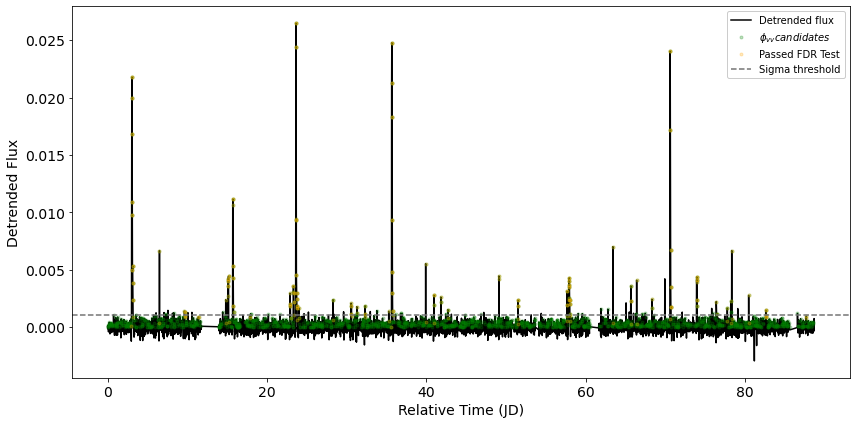

In [36]:
fig = plt.figure(figsize=(12, 6))
init_time = lc_table['time'].jd[0]

# Detrended flux
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.plot(lc_table['time'].jd - init_time, lc_table['flux_detrended'], color='black', label="Detrended flux")

# phi_vv candidates
ctimes = np.concatenate((ws_stat_table['time_1'][ws_stat_table['candidates']].data - init_time,
                         ws_stat_table['time_2'][ws_stat_table['candidates']].data - init_time))
candidates = np.concatenate((lc_table['flux_detrended'][:-1][ws_stat_table['candidates']].data,
                             lc_table['flux_detrended'][1:][ws_stat_table['candidates']].data))  
ax1.plot(ctimes, candidates, '.',color='green', alpha=0.25, label=r"$\phi_{vv} candidates$")

# Passed FDR
ftimes = np.concatenate((ws_stat_table['time_1'][ws_stat_table['pass_fdr']].data - init_time,
                         ws_stat_table['time_2'][ws_stat_table['pass_fdr']].data - init_time))
pass_fdr = np.concatenate((lc_table['flux_detrended'][:-1][ws_stat_table['pass_fdr']].data,
                           lc_table['flux_detrended'][1:][ws_stat_table['pass_fdr']].data))
ax1.plot(ftimes, pass_fdr, '.',color='orange', alpha=0.25, label="Passed FDR Test")

# Sigma threshold
ax1.axhline(sigma_thresh, linestyle="--",color="#737373", label="Sigma threshold")

ax1.set_xlabel("Relative Time (JD)", fontsize=14)
ax1.set_ylabel("Detrended Flux", fontsize=14)
ax1.legend(loc="upper right", framealpha=1)

fig.tight_layout()
plt.show()

Once we have our final list of flare points that pass all our tests, we turn it into a list of flares by finding flare edges for each point or group of points that passed the test. Flare edges are considered to be the first point that falls below the quiescent flux to either side of the starting point(s). We also discard flares within the given padding number of points of a light curve partition edge. This is because our detrending algorithm is not as good at the edges to flares found there are considered suspect.

In [37]:
flare_table = findflares.make_flare_list(ws_stat_table, lc_table, padding=0)

In [38]:
flare_table

start_ind,end_ind,start_time,end_time,peak_ind,max_flux
int64,int64,object,object,int64,float64
145,158,2455005.7486874172,2455006.014328829,149,0.021777230404166147
625,634,2455017.845548658,2455018.0294530573,630,0.00442166035062585
654,663,2455018.4585631485,2455018.6424673847,656,0.01115733455960572
1003,1010,2455025.651250453,2455025.7942865733,1004,0.002947001278116542
1021,1029,2455026.019057495,2455026.182527411,1025,0.0035649289869696555
1038,1049,2455026.366430835,2455026.591201782,1040,0.026464746063096352
1372,1377,2455033.293448086,2455033.416049827,1373,0.0020869361905535865
1619,1631,2455038.3814160977,2455038.626618931,1622,0.024766455269712516
2676,2689,2455060.592567019,2455060.8582000807,2682,0.004296273482567548


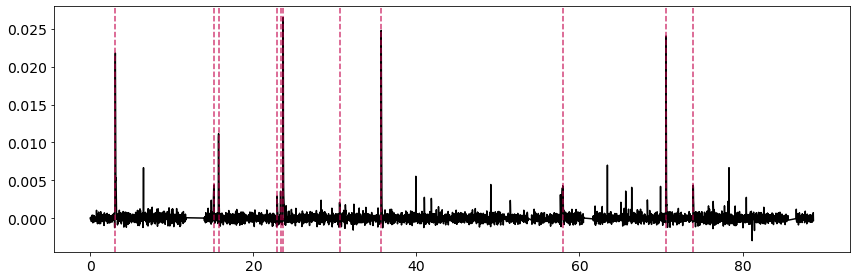

In [45]:
f, ax = plt.subplots(figsize=(12, 4))
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(lc_table['time'].jd - lc_table['time'][0].jd, lc_table['flux_detrended'], c='black')

for ind in flare_table["peak_ind"]:
    ax.axvline(lc_table['time'][ind].jd - lc_table['time'][0].jd, color='#c4004b', ls="--", alpha=0.75)
    

ax2.set_xlabel("Relative Time (Day)", fontsize=14)
ax2.set_ylabel("Relative Flux", fontsize=14)

plt.tight_layout()
plt.show()

## Kepler long cadence light curves

**Note:**  This step is not particularly slow, but it will take a few  minutes. It will also produce some warnings which can be safely ignored.

In [5]:
master_flare_table = None

lc_info_table.add_column(Column(name="phivv_stats_path",dtype="U128", length=len(lc_info_table)))
lc_info_table.add_column(Column(name="phivv_fit_params",dtype=float,shape=(5,), length=len(lc_info_table)))
lc_info_table.add_column(Column(name="pval_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="phivv_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="sigma_thresh",dtype=float, length=len(lc_info_table)))
lc_info_table.add_column(Column(name="num_flares_auto",dtype=int, length=len(lc_info_table)))

In [9]:
for lc_row in lc_info_table:
    
    # skipping the ones already done
    if lc_row['phivv_stats_path'] != "":
        continue
        
    # skipping the ones where the detrending failed
    if lc_row['score'] >= 2:
        continue
        
    # Getting the light curve
    lc_table = Table.read(lc_row["path"])
    
    # Performing all the flare finding statistics
    ws_stat_table, _ = findflares.phi_vv_stats(lc_table)
    hist_bins = findflares.get_hist_bins(ws_stat_table['phi_vv'][ws_stat_table['candidates']].max(),
                                         np.abs(ws_stat_table['phi_vv'][ws_stat_table['null_1'] | ws_stat_table['null_2']]).max(),
                                         verbose=False)
    fit_parameters, covariance = findflares.fit_phi_vv_histogram(ws_stat_table, hist_bins, verbose=False)
    findflares.calculate_pvals(ws_stat_table, hist_bins, fit_parameters)
    pval_thresh, thresh = findflares.perform_fdr_analysis(ws_stat_table, alpha=0.1, verbose=False)
    sigma_thresh = findflares.apply_sigma_threshold(lc_table, ws_stat_table, threshold=2.5, 
                                                    verbose=False, remove_artifacts=False)
    
    # Generating the list of flares
    flare_table = findflares.make_flare_list(ws_stat_table, lc_table, padding=0)
    
    phivv_stats_path = lc_row["path"].replace("lc.ecsv","stats.ecsv")
    ws_stat_table.write(phivv_stats_path, format="ascii.ecsv", overwrite=True)
    
    if len(flare_table):
        cols = flare_table.colnames
        flare_table["kid"] = lc_row["KID"]
        flare_table = flare_table[["kid"] + cols]
        
        if master_flare_table is None:
            master_flare_table = flare_table
        else:
            master_flare_table = vstack((master_flare_table, flare_table))
              
    lc_row['phivv_stats_path'] = phivv_stats_path
    lc_row['phivv_fit_params'] = fit_parameters
    lc_row['pval_thresh'] = pval_thresh
    lc_row['phivv_thresh'] = thresh
    lc_row['sigma_thresh'] = sigma_thresh
    lc_row['num_flares_auto'] = len(flare_table)

/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in exp
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWarning: overflow encountered in multiply
  return alpha * np.exp(-(x-a)/b) + beta * np.exp(-(x-a)/c)
/mnt/c/Users/cebra/Documents/Research/Papers/2022_Kepler_GALEX_Flares/git_repo/notebooks/../src/findflares.py:15: RuntimeWa

In [10]:
# Saving out the epxanded info table  (ecsv does not support multidimensional columns)
lc_info_table["phivv_fit_params"] = [str(x.tolist()) for x in lc_info_table["phivv_fit_params"]]
lc_info_table.write("../data_tables/kepler_longcad_info.ecsv",format="ascii.ecsv",overwrite=True)

In [11]:
# Saving the flare list
master_flare_table.write("../data_tables/loncad_flarelist.ecsv",format="ascii.ecsv",overwrite=True)